<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Utils---Methods" data-toc-modified-id="Utils---Methods-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Utils - Methods</a></span></li><li><span><a href="#Analyzation" data-toc-modified-id="Analyzation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analyzation</a></span></li></ul></div>

# Utils - Methods 

We only want to consider two labelled images due to the simplicity of color and domains. In this case we just need to analyze three labels (wound, skin, and the background):
- OpenCV is used to work with the images 
- Convert the image colors to labelled colors pixels 

In [2]:
import cv2
import numpy 
import sklearn 
import matplotlib.pyplot as plt 
from skimage import measure
import matplotlib.pyplot as plt
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from scipy.ndimage import zoom
from tqdm.notebook import tqdm

In [3]:
#Reading the images by numpy
"""
Input: The path to images (list of paths)
Output: List of images which were converted to array
"""
def read_img(img_path):
    res = {}
    for img in tqdm(img_path): 
        print("Woking on image with path {}".format(img))
        res[img] = cv2.imread(img)
    return res


"""
Input: List of images which were converted to array
Output: List of images which are converted to grayscale
"""
def gray_scale(images):
    res = {}
    for key in tqdm(images.keys()):
        res[key] = cv2.cvtColor(images[key],cv2.COLOR_RGB2GRAY)
    return res


"""
Input: List of images which were converted to grayscale
Output: List of images which are converted to labels
"""
def convert_label(gray_imgs):
    res = {}
    for key in tqdm(gray_imgs.keys()):
        res_img = np.zeros((gray_imgs[key].shape[0],gray_imgs[key].shape[1]),dtype ="uint8")
        for i in tqdm(range(gray_imgs[key].shape[0])):
            for j in range(gray_imgs[key].shape[1]):
                if(gray_imgs[key][i,j] == 255):
                    res_img[i,j] = int(0) #if the pixel is background
                elif(gray_imgs[key][i,j] == 128):
                    res_img[i,j] = int(1) #if the pixel is skin
                elif(gray_imgs[key][i,j] == 55):
                    res_img[i,j] = int(2) #if the pixel is the wound
                elif(gray_imgs[key][i,j] == 33):
                    res_img[i,j] = int(0) #if the pixel is background
        res[key] = res_img
    return res         


"""
Input: List of images which are converted to labels
Output: Return center of mass of the wound
"""
def com(imgs):
    com = {}
    for key in tqdm(imgs.keys()):
        props = measure.regionprops(np.array(imgs[key])) #get the centroid of each image
        com[key] = props[1].centroid #store the centroids of images to a dict
        print("The center of mass of the wound in image {} is: {}".format(key,com[key]))
    return com


"""
Input: Center of Mass of the Wound in each images
Output: Boxes of Mass of the Wound, width (com-width/8,com+width/8)
        length (com-length/8,com+length/8)
"""
def centroid_sq(com,imgs): 
    square = {}
    for key in tqdm(com.keys()):
        width = imgs[key].shape[0]
        length = imgs[key].shape[1]
        img = imgs[key]
        centroid = com[key]
        square[key] = img[int(centroid[0]-width/8):int(centroid[0] + width/8),
                                int(centroid[1]-length/8):int(centroid[1] + length/8)]
        print("The images {} has a small windows with shape:{}".format(key,square[key].shape))
    return square

"""
Input: windows = centroid_sq(com,imgs), res_labels, com_res
Output: Two frame with same size 
"""
def mapping_com(windows,res_labels,com_res):
    origin_key = list(res_labels.keys())[0]
    other_key = list(res_labels.keys())[1]
    origin = res_labels[list(res_labels.keys())[0]]
    print("The origin image is {}".format(origin_key))
    window = windows[other_key]
    lower_x = int(com_res[origin_key][0]-window.shape[0]/2)
    lower_y = int(com_res[origin_key][1]-window.shape[1]/2)
    upper_x = int(com_res[origin_key][0]+window.shape[0]/2)
    upper_y = int(com_res[origin_key][1]+window.shape[1]/2)
    print("The lower_x is {}, the upper_x is {}, the lower_y is {}, the upper_y is {}".format(lower_x,upper_x,lower_y,upper_y))
    print("Getting the small windows of the origin image")
    origin = origin[lower_x:upper_x,lower_y:upper_y]
    return origin,window

"""
Input: Images that need to rotate and original image
Output: Rotation Matrix 
"""
def rotateImage(image, angle):
    (h,w) = image.shape[:2]
    center = (w/2,h/2)
    M = cv2.getRotationMatrix2D(center,angle,1.0)
    rotated_image = cv2.warpAffine(image, M, (w,h))
    return rotated_image

"""
Note: Trying the case where consider the dot product
Input: 2 images, steps of increasing step
Output: Maximum Angle with the maximum rotation between two frames
"""
def rotation_param(ori,img,step_size = 5):
    res = {}
    angle = 0
    while (angle <= 360):
        res[angle] = np.sum(np.multiply(ori,rotateImage(img,angle)))/(np.linalg.norm(ori)*np.linalg.norm(img))
        angle+= step_size
    return max(res, key=res.get)

"""
Note: Trying the case where consider the match value of wound
Input: 2 images, steps of increasing step
Output: Maximum Angle with the maximum rotation between two frames
"""
def match_angle(ori,img,step_size = 5):
    res = {}
    num_match = 0
    angle = 0
    while (angle <=360):
        img_rt = rotateImage(img,angle)
        for row in range(img.shape[0]):
            for col in range(img.shape[1]):
                if(img_rt[row,col] == origin[row,col]):
                    num_match+=1
        res[angle] = num_match
        num_match = 0
        angle += step_size 
    return max(res,key=res.get)
"""
Input: Images that need to zoom
Output: Zoom Matrix 
"""
def clipped_zoom(img, zoom_factor):

    h, w = img.shape[:2]
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)

    # Zooming out
    if zoom_factor < 1:

        # Bounding box of the zoomed-out image within the output array
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        # Zero-padding
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = zoom(img, zoom_tuple)

    # Zooming in
    elif zoom_factor > 1:

        # Bounding box of the zoomed-in region within the input array
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        out = zoom(img[top:top+zh, left:left+zw], zoom_tuple)

        # `out` might still be slightly larger than `img` due to rounding, so
        # trim off any extra pixels at the edges
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]

    # If zoom_factor == 1, just return the input array
    else:
        out = img
    return out

def match_zoom(ori,img,step_size = 0.1):
    res = {}
    num_match = 0
    scale = 0.1
    while (clipped_zoom(img,scale).shape == ori.shape):
        img_rt = clipped_zoom(img,scale)
        for row in range(img.shape[0]):
            for col in range(img.shape[1]):
                if(img_rt[row,col] == origin[row,col]):
                    num_match+=1
        res[scale] = num_match
        num_match = 0
        scale += step_size 
    return max(res,key=res.get)

    

# Analyzation

For analysis, it is easier when we consider gray scale of images then convert the images to different labels (3 labels representing background, skin, wound). 
- imgs: reading the images by cv2
- grays: converting images to grayscale
- res_labels: converting the images to labels 
- com_res: getting the center of mass of images
- square: getting the small windows of images

Sequence of finding the angle between two image: 
- 1. Reading the images and put into dictionary
- 2. Converting the images into grayscale 
- 3. Converting the images into labels (0,1,2)
- 4. Getting the center of mass of the wounds 
- 5. Getting the small windows of the images 
- 6. Map the center of mass between two images 
- 7. Consider matched pixels
- 8. Rotate the image with the calculated angle 
- 9. Considering zoom two an image 
- 10. Consider matched pixels
- 11. Return tuples (angle, rotation)


In [14]:
"""
Necessary Variables: 
IMG_PATH: List of images path
JUST NEED TO INPUT THE PATH TO IMAGES
"""
IMG_PATH = {"6.png","8.png"}

In [6]:
imgs = read_img(IMG_PATH) #Read the images with the image path
print("------------------------")
for key in imgs.keys(): #Loop through each image and print out the shape of image
    print("The shape of image {} is {}".format(key,imgs[key].shape))

print("------------------------")
print("Converting to gray scale")
grays = gray_scale(imgs)
for key in grays.keys(): #Loop through each image and print out the shape of image
    print("The shape of image {} is {}".format(key,imgs[key].shape))

print("------------------------")
print("Converting gray scale to labels")
res_labels = convert_label(grays)
print("Finished converting gray scale to labels")

print("------------------------")
print("Getting the center of mass of the images")
com_res = com(res_labels)
print("Finished getting the center of mass")

print("------------------------")
print("Getting the small windows of images")
windows = centroid_sq(com_res,res_labels)
print("Finished getting the windows of images")


print("------------------------")
print("Getting the frame of images")
origin, other = mapping_com(windows,res_labels,com_res)
print("Finished getting the frames of images")

print("------------------------")
print("Getting the angle of rotation of images")
print("With Method 1 (Dot Product), the angle is {}".format(rotation_param(origin,other,step_size = 5)))
print("With Method 2 (Pixels Match), the angle is {}".format(match_angle(origin,other,step_size = 5)))
angle = match_angle(origin,other,step_size = 5)
img_rotated = rotateImage(other,angle)

print("------------------------")
print("Getting the zoom match of images")
zoom_scale = match_zoom(origin,img_rotated)

print("The zoom scale of image is: {}".format(zoom_scale))
print("The (angle, zoom) scale of {} compare to {} is: {}".format(next(iter(IMG_PATH)),next(iter(IMG_PATH)),(angle,zoom_scale)))

Woking on image with path 8.png
Woking on image with path 6.png

------------------------
The shape of image 8.png is (768, 1024, 3)
The shape of image 6.png is (768, 1024, 3)
------------------------
Converting to gray scale



The shape of image 8.png is (768, 1024, 3)
The shape of image 6.png is (768, 1024, 3)
------------------------
Converting gray scale to labels




Finished converting gray scale to labels
------------------------
Getting the center of mass of the images


The center of mass of the wound in image 8.png is: (394.4274647313056, 502.2333034330914)
The center of mass of the wound in image 6.png is: (375.20123753867307, 307.6773117909935)

Finished getting the center of mass
------------------------
Getting the small windows of images


The images 8.png has a small windows with shape:(192, 256)
The images 6.png has a small windows with shape:(192, 256)

Finished getting the windows of images
------------------------
Getting the frame of images
The origin image is 8.png
The lower_x is 298, the upper_x is 490, the lower_y is 374, the upper_y is 630
Getting the small windows of the origin image
Finished getting the frames of images
------------------------
Getting the angle of rotation of images
With Method 1 (Dot Product), the angle is 0
With Method 2 (Pixels Match), the angle is 275
------------------------
Getting the zoom match of images
The zoom scale of image is: 1.3
The (angle, zoom) scale of 8.png compare to 8.png is: (275, 1.3)


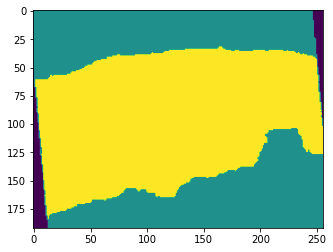

In [9]:
plt.imshow(clipped_zoom(img_rotated,1.3))


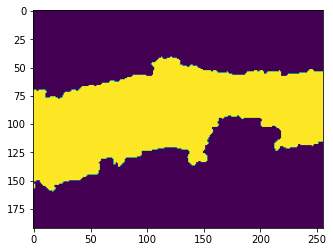

In [10]:
plt.imshow(origin)

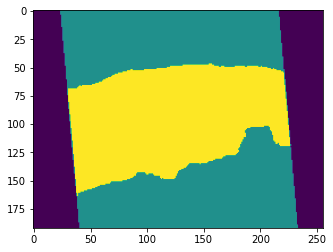

In [13]:
plt.imshow(clipped_zoom(img_rotated,1))

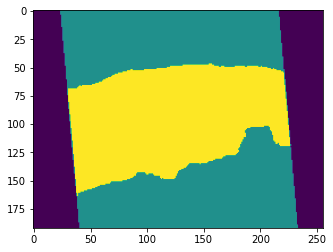

In [11]:
plt.imshow(img_rotated)